In [1]:
import numpy as np
from pathlib import Path
import glob
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import signal
import re

import datain

In [2]:
def getfft(data, t_arr=np.array([])):
    datafft=np.zeros(np.shape(data))+1j*0
    Ns=np.shape(data)[1]
    
    if t_arr.size>0:
        dt=t_arr[1]
        freq=np.fft.fftshift(np.fft.fftfreq(Ns,dt))
        datafft=np.fft.fftshift(np.fft.fft(data,axis=1)/(Ns/2),axes=1)#Ns)
        del data, t_arr
        return datafft, freq
    else:
        datafft=np.fft.fftshift(np.fft.fft(data)/(Ns/2))#Ns)
        del data
        return datafft
    
def submean(data):
    datare=data-data.mean()
    del data
    return datare

def decimate(data,tarr=np.array([]), decfactor=1):
    target_rows=int(data.shape[0]/decfactor)
    decimated=np.zeros((target_rows,data.shape[1]))
    for col in np.arange(0,np.shape(data)[1]):
        reshaped=data[:,col].reshape(target_rows,decfactor)
        decimated[:,col]=np.mean(reshaped,axis=1)
#     print('dec',np.isnan(decimated))
#     print('resh',np.isnan(reshaped))

    if tarr.size>0:
        tarre=tarr[::decfac]
        del data, tarr
        return decimated, tarre
    else:
        del data
        return decimated
    
def alignData(EC_data=np.array([]),time_EC=np.array([]),data_X=np.array([]),time_X=np.array([]),ECstart=0,MskThreshold=.3,plots=False):
    #Attempts to align data from labview hardware to same time as that collected
    #by the multichannel (MC) detector with FFT cross-correlation. Incident X-ray 
    #signal is used as marker between the data sources.
    #
    #Big question remaining is conversion factor between counts on multichannel detector
    #and voltage on labview hardware.
    #Should labview data be averaged down to MC sampling rate or stepped over?
    
    mask=EC_data[:,1]>MskThreshold
    print(mask.argmax())    
    
    EC_M=EC_data[mask]
    t_EC_M=time_EC[mask]
    
    EC_dwnS_M,t_EC_dwnS_M=decimate(EC_M,t_EC_M,decfactor=decfac)

#     EC_dwnS=EC_data[ECstart::10]
#     t_EC_dwnS=t_EC[ECstart::10]



    
    time_EC_dwnS_M=np.delete(time_EC_dwnS_M[mask],np.arange(0,ECstart))
    EC_dwnS_M=np.delete(EC_dwnS[mask],np.arange(0,ECstart),axis=0)
        
    nsamples_X=data_X.size
    nsamples_EC=t_EC_dwnS_M.size

    dt = np.arange(1-nsamples_X, nsamples_EC)

    EC_t0=t_EC_dwnS_M[0]
    t_EC_dwnS_M=t_EC_dwnS_M-EC_t0

    Io_EC_N=EC_dwnS_M[:,1]-EC_dwnS_M[:,1].mean();Io_EC_N/=Io_EC_N.max()
    Io_N=data_X-data_X.mean();Io_N/=Io_N.max()

    corr=signal.correlate(Io_EC_N,Io_N,mode='full',method='fft')/(np.mean([nsamples_EC,nsamples_X]))

    shifts, shift_props=signal.find_peaks(corr,height=.95*corr.max(),distance=10)

    shift_ind=dt[shifts[shift_props['peak_heights'].argmax()]]
    shift_time=shift_ind*t_EC_dwnS_M[1]
    
    rolled_Io_EC_N=np.roll(Io_EC_N,-shift_ind)

    
    if nsamples_EC>=nsamples_X:
        diff=np.sum((rolled_Io_EC_N[:nsamples_X]-Io_N)**2)/nsamples_X
    elif nsamples_X>nsamples_EC:
        diff=np.sum((rolled_Io_EC_N-Io_N[:nsamples_EC])**2)/nsamples_EC

    if plots==True:
        fig, (ax_Io, ax_IoC, ax_corr,ax_R) = plt.subplots(4, 1,figsize=(10,10))

        ax_Io.plot(t_X,data_X/data_X.mean())
        ax_Io.set_title('Multichannel Io Raw')
        ax_IoC.plot(t_EC_dwnS_M,Io_EC_N+2,label='LV')
        ax_IoC.plot(t_X,Io_N,label='MC')
        ax_IoC.set_title('Zero mean and Normalized to Max Value')
        ax_IoC.legend()
        # ax_IoC.set_ylim(1,3)
        ax_corr.plot(corr)
        ax_corr.plot(shifts,corr[shifts],'x')
        ax_corr.set_title('Cross-correlation Function')
        # ax_corr.set_ylim(2.5,4)
        ax_R.plot(t_EC_dwnS_M,rolled_Io_EC_N+2,label='LV')
        ax_R.plot(t_X,Io_N,label='MC')
        ax_R.legend()
        ax_R.set_title('Time ')
        fig.tight_layout()
        fig.show()
        plt.title("Time shifted" + str(shift_time))

        
#     print(ECstart,diff, shift_time)
    
    
#     return np.array([diff,shift_time,shift_props['peak_heights'].max(),mask])
    return mask

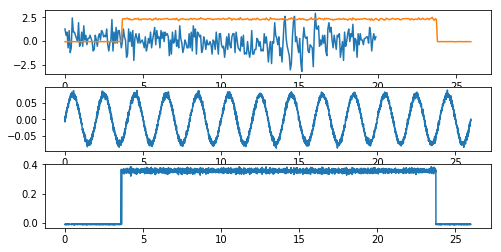

In [3]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\June 2019 Test Data\0.5 Hz'
path2=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\June 2019 Test Data\0.5 Hz EC'

X_allfiles=glob.glob(path + '\Amplitude Find 2\A1')
EC_allfiles=glob.glob(path2 + '\Amplitude Find 2\A1\A? 1*.txt')


#Reading in data from multichannel detector
data_X=pd.read_csv(X_allfiles[0],delimiter='\t', header=0,engine='python')

X_mask=data_X.iloc[:,4]>0


t_X=np.array(data_X.loc[data_X['ROI1_Ch4']>0,'Time'])
Io_X=np.array(data_X.loc[data_X['ROI1_Ch4']>0,'I0'])
If_X=np.array(data_X.loc[data_X['ROI1_Ch4']>0,'ROI1_Ch1':'ROI1_Ch8'])

ChAvg=np.average(If_X,axis=1)
Ir_X=ChAvg/Io_X

Iomean_X=np.mean(Io_X)
Ifmean_X=np.mean(ChAvg)
Irmean_X=np.mean(Ir_X)


datan_X=np.array([submean(Ir_X),submean(Io_X),submean(ChAvg)])

dt_X=t_X[1]
Ns_X=np.shape(ChAvg)[0]

##Reading in data from labview system
data_EC=np.zeros(1)
for ECfile in EC_allfiles:  
    readEC=pd.read_csv(ECfile,index_col=False,skiprows=1,delimiter='\t', header=None,engine='python')
    readEC.columns=('Time','Io','If','J','V','If2')
    if np.ndim(data_EC)==1:
        data_EC=np.array(readEC)
        nrows=np.shape(readEC)[0]
    elif np.shape(readEC)[0]>=nrows:
        data_EC=np.concatenate((data_EC,readEC),axis=0)

dt_EC=data_EC[1,0]
t_EC=np.arange(0,len(data_EC)*dt_EC,dt_EC)

Iomean_EC=data_EC[:,1].mean()
Ifmean_EC=data_EC[:,2].mean()

datan_EC=np.array([submean(data_EC[:,1]),submean(data_EC[:,2]),submean(data_EC[:,3]),submean(data_EC[:,4])])

EC_dwnS=data_EC[::10,:]
t_EC_dwnS=t_EC[::10]
fig=plt.figure(figsize=(8,4))

ax1=fig.add_subplot(311)
ax1.plot(t_X,submean(Io_X)/Io_X.std(),t_EC_dwnS,EC_dwnS[:,1]/EC_dwnS[:,1].std())#/EC_dwnS[:,1].mean())
ax1=fig.add_subplot(312)
ax1.plot(t_EC,data_EC[:,4])
ax1=fig.add_subplot(313)
ax1.plot(t_EC,data_EC[:,1])

In [4]:
fig.savefig('MultiChannel Time.png')

In [8]:
EC_data=data_EC.copy()
ECstart=0
MskThreshold=.3
decfac=10
reps=1

results=np.zeros((reps,4))

# for nex in np.arange(0,reps):
#     results[nex,0]=nex
#     results[nex,1:]=alignData(data_EC,Io_X, ECstart=nex,plots=False)
    
# print(results[:,1].argmin(),results[:,1].min())
decmask=alignData(data_EC,t_EC,Io_X,t_X, ECstart=0,plots=True)


674


ValueError: cannot reshape array of size 3021 into shape (302,10)

In [9]:
Fulmask=EC_data[:,1]>.3

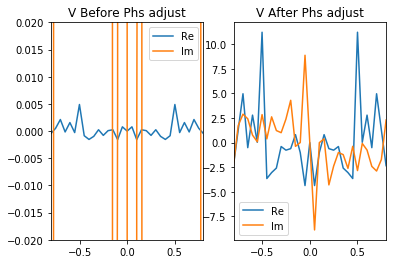

In [11]:
fa=0.5

datafft, freq=getfft(datan,t)
fftang=np.angle(datafft)
fftmag=np.abs(datafft)
bin1=datain.fftbin(fa,freq,Ns,dt,"Real",1)
bina=int(bin1[1])

fig=plt.figure(figsize=(6,4))
ax1=fig.add_subplot(121)

ax1.plot(freq,np.real(datafft[0,:]),freq,np.imag(datafft[2,:]))
ax1.set_xlim(-1.6*fa,1.6*fa)
ax1.set_ylim(-.02,.02)
ax1.set_title('V Before Phs adjust')
ax1.legend(['Re','Im'])
ax1=fig.add_subplot(122)

ax1.plot(freq,np.real(datafft[2,:]),freq,np.imag(datafft[2,:]))
ax1.set_xlim(-1.6*fa,1.6*fa)
ax1.set_title('V After Phs adjust')
ax1.legend(['Re','Im'])
# ax1.set_ylim(0,.001)
plt.show()


# angadj=fftang[2,int(bin1[1])]+np.pi/2 #Voltage phase correction


In [37]:
start=1
decfactor=10
tar_rows=int(EC_data[start:,:].shape[0]/decfactor)
EC_data2=EC_data[start:,:]
# print(EC_data[11:,:].shape[0] % decfactor)
# np.remainder()
EC_data2=EC_data[start:,0].reshape(tar_rows,decfactor)

ValueError: cannot reshape array of size 3899 into shape (389,10)

In [58]:
print(np.arange(0,3))

[0 1 2]


[543] [3564]
3021


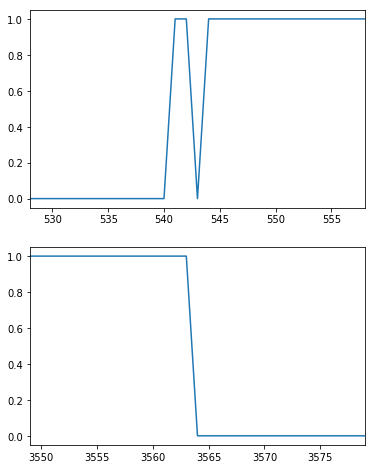

In [40]:
Fulmask=data_EC[:,1]>.3
peak,peakprop=signal.find_peaks(Fulmask,width=10)



fig=plt.figure(figsize=(6,8))
ax1=fig.add_subplot(211)
ax1.plot(Fulmask)
ax1.set_xlim(peakprop['left_bases'][0]-15,peakprop['left_bases'][0]+15)
ax1=fig.add_subplot(212)
ax1.plot(Fulmask)
ax1.set_xlim(peakprop['right_bases'][0]-15,peakprop['right_bases'][0]+15)

print(peakprop['left_bases'],peakprop['right_bases'])
print(peakprop['right_bases'][0]-peakprop['left_bases'][0])

In [26]:
print(peakprop['left_bases'][0],peakprop['right_bases'][0])

678 3697


In [32]:
3696-679

3017

In [31]:
Fulmask[3697]

False

In [41]:
X_mask

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
       ...  
270     True
271     True
272     True
273     True
274     True
275     True
276     True
277     True
278     True
279     True
280     True
281     True
282     True
283     True
284     True
285     True
286     True
287     True
288     True
289     True
290     True
291     True
292     True
293     True
294     True
295     True
296     True
297     True
298     True
299    False
Name: ROI1_Ch2, Length: 300, dtype: bool

In [56]:
Io_Expand=np.repeat(Io_X,10)

C:\Users\shadd\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\shadd\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Text(0.5, 1.0, 'Time shifted: 0.12666672999999973')

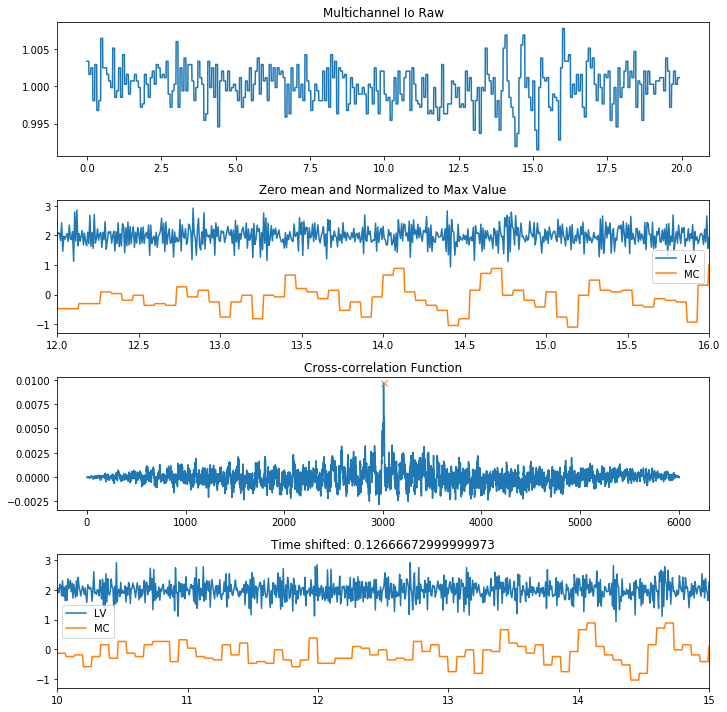

In [5]:
##Some new cross correlation shit

mask=data_EC[:,1]>.3
peak,peakprop=signal.find_peaks(mask,width=10)

EC_M=data_EC[peakprop['left_bases'][0]+1:peakprop['right_bases'][0],1]
t_EC_M=t_EC[peakprop['left_bases'][0]+1:peakprop['right_bases'][0]]
t_EC_M-=t_EC_M[0]

Io_Expand=np.repeat(Io_X,10)

# Io_X2=Io_X-Io_X.mean();Io_X2/=Io_X2.max()

# n = Io_X.shape[0]
# Io_Expand = np.zeros((10*n,),dtype=Io_X.dtype)
# Io_Expand[::10] = Io_X2

t_X_Expand=np.arange(0,Io_Expand.size*t_X[1]/10-t_X[1]/10,t_X[1]/10)




nsamples_X=Io_Expand.size
nsamples_EC=EC_M.size

dt = np.arange(1-nsamples_X, nsamples_EC)


Io_EC_N=EC_M-EC_M.mean();Io_EC_N/=Io_EC_N.max()
Io_N=Io_Expand-Io_Expand.mean();Io_N/=Io_N.max()

corr=signal.correlate(Io_EC_N,Io_N,mode='full',method='fft')/(np.mean([nsamples_EC,nsamples_X]))

shifts, shift_props=signal.find_peaks(corr,height=.95*corr.max(),distance=10)


shift_ind=dt[shifts[shift_props['peak_heights'].argmax()]]
shift_time=shift_ind*t_EC_M[1]

rolled_Io_EC_N=np.roll(Io_EC_N,-shift_ind)


if nsamples_EC>=nsamples_X:
    diff=np.sum((rolled_Io_EC_N[:nsamples_X]-Io_N)**2)/nsamples_X
elif nsamples_X>nsamples_EC:
    diff=np.sum((rolled_Io_EC_N-Io_N[:nsamples_EC])**2)/nsamples_EC

    
fig, (ax_Io, ax_IoC, ax_corr,ax_R) = plt.subplots(4, 1,figsize=(10,10))

ax_Io.plot(t_X_Expand,Io_Expand/Io_Expand.mean())
ax_Io.set_title('Multichannel Io Raw')
ax_IoC.plot(t_EC_M,Io_EC_N+2,label='LV')
ax_IoC.plot(t_X_Expand,Io_N,label='MC')
ax_IoC.set_title('Zero mean and Normalized to Max Value')
ax_IoC.legend()
ax_IoC.set_xlim(12,16)
# ax_IoC.set_ylim(1,3)
ax_corr.plot(corr)
ax_corr.plot(shifts,corr[shifts],'x')
ax_corr.set_title('Cross-correlation Function')
# ax_corr.set_ylim(2.5,4)
ax_R.plot(t_EC_M,rolled_Io_EC_N+2,label='LV')
ax_R.plot(t_X_Expand,Io_N,label='MC')
ax_R.legend()
ax_R.set_title('Time ')
ax_R.set_xlim(10,15)
fig.tight_layout()
fig.show()
plt.title("Time shifted: " + str(shift_time))

In [7]:
fig.savefig('Multichannel Cross correlation.png')

In [63]:
peakprop['left_bases'][0]+1

544

In [64]:
peakprop['right_bases'][0]

3564

In [74]:
n = Io_X.shape[0]
out = np.zeros((10*n,),dtype=Io_X.dtype)
out[::10] = Io_X